# Practical 4 - Training Neural Networks
In this practical, we will focus on how to effectively train a neural network 

We will be training a model to classify a small image into 100 different classes/labels.

## Imports

In [1]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import datasets
from keras import layers
from keras import optimizers
from keras import regularizers
from keras import losses,metrics
from keras import models
from keras import callbacks

from datetime import datetime
from functools import partial
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

import baseline_model
import cnn_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

#%env CUDA_VISIBLE_DEVICES="" # turn off gpu if present
tf.set_random_seed(0) # seed rng

Using TensorFlow backend.


## Sourcing the Data
We will be working with the CIFAR 10 dataset: a 10 class/label image classification dataset.  

<div style="text-align: center">
    <img style="display: inline-block" src="https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png"/>
    <b style="display: block"> Images from CIFAR 10 dataset </b>
</div>

The task is to classify the 32 by 32 color images into 10 categories.

Loading the data is simple as the dataset is built into Keras:

In [2]:
(train_imgs, train_labels), (valid_imgs, valid_labels) = datasets.cifar10.load_data()

## Exploring the Data
Lets visualise a random example in the dataset:

Text(0.5, 1.0, 'label: 7')

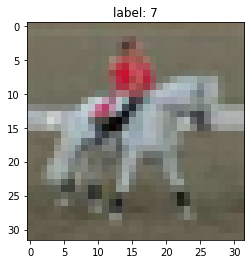

In [3]:
# select a random example in the training set to visualise
rand_idx = random.randint(0, len(train_imgs))
rand_img = train_imgs[rand_idx]
rand_label = train_labels[rand_idx][0]

# visualise the image and the corresponding label
plt.imshow(rand_img)
plt.title(f"label: {rand_label}")

As you can see the label has already been converted to integer for us.  
That the data preparation work that we have to do, but a integer is not very interpretable.  
We would like to have string label like  'frog' instead of a integer label '6'.
To do this we construct a dictionary to map from integer label to string labels:

In [4]:
# load the metadata for the dataset from disk
meta_path = os.path.expanduser(os.path.join(
    "~", ".keras", "datasets", "cifar-10-batches-py", "batches.meta"))
with open(meta_path, "rb") as f:
    meta = pickle.load(f)

# build label mapping dictionary
label_names = meta["label_names"]
label_map = {}
for label_int, label in enumerate(label_names):
    label_map[label_int] = label

Now we can visualise image with an interpretable label:

Text(0.5, 1.0, 'label: horse')

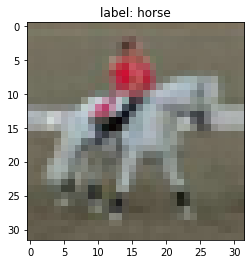

In [5]:
# visualise the image and the corresponding label
plt.imshow(rand_img)
plt.title(f"label: {label_map[rand_label]}")

Typically you explore the data further to see how you can improve your dataset before going further. In the interest of time we will skip that and say:
- cifar-10 has no class imbalance issues.
- cifar-10 has no missing values.

So the hard work has already been completed for you.

## Preparing the data
Now we proceed with preparing the data for ML.

But first some background on the representation of the images:   
images are represented in the dataset as numpy arrays  with the shape `[height, width, channel]`:

<div style="text-align: center">
    <img alt="Image Shape" width="300" src="http://corochann.com/wp-content/uploads/2017/04/cnn_diagram_notation.png" />
    <p>
        <b> Channel dimension stores the red, green and blue values </b>
    </p>
</div>

Each 'pixel' in the numpy array ranges from  0 - 255, with 255 as the largest value.

### Feature Normalisation
First we perform feature normalisation on the input images:
- only mean normalisation (subtract mean from image) is required as the pixel come form the same scale (0 - 255)

In [6]:
# Perform feature scaling - mean normalisation 
mean_img = np.mean(train_imgs, axis=0)
pp_train_imgs = (train_imgs - mean_img)
pp_valid_imgs = (valid_imgs - mean_img)

### Encoding the Labels
As usual, we one hot encode the labels as one hot vectors to enforce the  
idea of categorical to the model.

In [7]:
encoder = OneHotEncoder(categories="auto")
encoder.fit(train_labels)
pp_train_labels = encoder.transform(train_labels).toarray()
pp_valid_labels = encoder.transform(valid_labels).toarray()

Typically, you do not sample your data, instead you train your model on all the data you have.  
In this practical we will artificially limiting the training set to 1/5 of the dataset to observe the effects of too little data.

In [8]:
# Compute new training set size
sample_train_size = len(train_imgs) // 5
# sample the trainng example without replacement
sample_pp_train_imgs, sample_pp_train_labels = resample(
    pp_train_imgs, pp_train_labels, 
    n_samples=sample_train_size,
    replace=False)

## Building the Model
Now that data preprocessing has been complete, we can now preceed to build  
a model to classify the image. Since this practical focuses on the training  
process, we will provide a model generation function for you. 

Generate the model using `build_model()`: There are some parameters you can configure:
- `input_shape` - the shape of the inputs (in this case images) given to the neural network.
- `n_output` - no. of outputs in the neural network. Set this to the no. of classes/labels
- `scale_width` - increasing this multiples the no. of hidden units used per layer. 
- `scale_depth` - no. of hidden layers in the network.
- `activation` -  the activation function to use in the network. Good choices are Relu, Elu, Selu
- `l2_lamda` - amount of L2 regularisation to add.

In [9]:
# pass the input and no of classes (n_outputs) to build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=1, scale_depth=3,
    activation=layers.ReLU,
    l2_lambda=0)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                196672    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 64)                0         
__________

## Training the Model
Now we proceed with training the model. In Keras, there are two steps to   
training the model:  
1. `.compile()` to compile the model
    - Here you will specify the the loss function to minimize,
      optimizer that will minimise the loss function (with the corresponding
      learning rate) and the metrics to record during training/evaluation  
2. `.fit()` to actually train the mode
    - train the model by specifying the training data for training,
      validation data for metrics during training, the batch size and 
      no. of epochs/the model passes over the data to train.
    - optionally you can specify some usefully callbacks to add
      functionality during training

### Compling the model
We first compile the model by calling `.compile()` with:
- the loss function to minimise:
    - classification task
        - use `binary_crossentropy` for 2-class/label classification
        - use `categorical_crossentropy` for multi-class/label classification
    - regression task
        - use `mean_squared_error` for regression
- the optimizer that will minimise the loss function.
    - recommanded choice: `Adam` or `Nadam`
    - metrics to evaluate the model during training (ie accuarcy)

In [11]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(),
    metrics=["accuracy"])

### Fitting the model
Now we can fit the model to the training data by calling `.fit()`:
- provide the training set for the model to train on
- provide the validation set for the model to evaluate on
- tell the model only many to fit on at once with `batch_size`
> If you are training on a hardware accelerator like a GPU, you might want to increase
> `batch_size` to take advantage of your GPU

In [12]:
# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 107us/step - loss: 13.5470 - acc: 0.1556 - val_loss: 13.4733 - val_acc: 0.1627
Epoch 2/10
10000/10000 [==============================] - 1s 76us/step - loss: 13.4343 - acc: 0.1649 - val_loss: 13.2572 - val_acc: 0.1767
Epoch 3/10
10000/10000 [==============================] - 1s 63us/step - loss: 13.6097 - acc: 0.1548 - val_loss: 13.6282 - val_acc: 0.1539
Epoch 4/10
10000/10000 [==============================] - 1s 65us/step - loss: 13.4754 - acc: 0.1635 - val_loss: 13.5978 - val_acc: 0.1562
Epoch 5/10
10000/10000 [==============================] - 1s 72us/step - loss: 13.5488 - acc: 0.1591 - val_loss: 13.5506 - val_acc: 0.1590
Epoch 6/10
10000/10000 [==============================] - 1s 73us/step - loss: 13.5506 - acc: 0.1588 - val_loss: 13.6250 - val_acc: 0.1543
Epoch 7/10
10000/10000 [==============================] - 1s 62us/s

Looking the metrics looss and accuracy, they seem to be barely improving at all.
Lets evaluate the model to investigate what the problem is.

## Evaluating the Model
We evaluate the model to determine why the model does not train.

There is a tool included with `tensorflow` called `tensorboard` that makes it easier to evaluate neural networks  
For `tensorboard` to work we have to admend your `.fit()` call:

In [13]:
# pass the input and no of classes (n_outputs) to build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=1, scale_depth=3,
    activation=layers.ReLU,
    l2_lambda=0)

# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(),
    metrics=["accuracy"])

### New stuff:
# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=10,
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 77us/step - loss: 13.3534 - acc: 0.1666 - val_loss: 13.1322 - val_acc: 0.1828
Epoch 2/10
10000/10000 [==============================] - 1s 71us/step - loss: 13.5912 - acc: 0.1556 - val_loss: 13.4534 - val_acc: 0.1642
Epoch 3/10
10000/10000 [==============================] - 1s 68us/step - loss: 13.4192 - acc: 0.1666 - val_loss: 13.3650 - val_acc: 0.1700
Epoch 4/10
10000/10000 [==============================] - 1s 64us/step - loss: 13.4634 - acc: 0.1643 - val_loss: 13.4700 - val_acc: 0.1635
Epoch 5/10
10000/10000 [==============================] - 1s 68us/step - loss: 13.3075 - acc: 0.1738 - val_loss: 13.2751 - val_acc: 0.1760
Epoch 6/10
10000/10000 [==============================] - 1s 75us/step - loss: 13.3752 - acc: 0.1698 - val_loss: 13.4357 - val_acc: 0.1663
Epoch 7/10
10000/10000 [==============================] - 1s 77us/step - loss: 13.5495 - acc: 0.1591 - val_loss: 13.

After training is complete, we have to run the Tensorboard server by:
- opening a new terminal in Jupyter Lab (File>New>Terminal)
- Running the tensorboard server and pointing the server to the logs with `tensorboard --log-dir=logs`
- Point a new tab at http://localhost:6006

<div style="text-align: center">
    <h5> Tensorboard UI </h5>
    <img src="https://www.tensorflow.org/images/mnist_tensorboard.png" width=500/>
</div>

Looking at the training loss `loss` we can see that the model having problems fitting the   
the training data (its not decreasing much at all).

> When this happens the model is having problems **converging** to a lower loss 

When this happens, its time to tune your learning rate.

## Iterate. 
### Learning Rate Tuning
Tuning the learning rate is arguablely the important hyperparameter you have to tune when training
neural networks:
- set the learning rate too high and metrics do not improve or even explode (increase rapidly) during 
- set the learning rate too low and the neural network takes forever (figure of speech) to train

<img alt="learning rate tuning" src="https://cdn-images-1.medium.com/max/1200/0*RgLvNta2lZVBtPoc." width=300/>

We seem to have a high learning rate problem, so we set the learning rate from  
the default value of `1e-3` to `1e-4`.

> `1e-4` is eqivilent to $1 \times 10^{-4}$

In [14]:
# pass the input and no of classes (n_outputs) to build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=1, scale_depth=3,
    activation=layers.ReLU,
    l2_lambda=0, dropout_prob=0.0)

# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=1e-4), # Lowered the learning rate
    metrics=["accuracy"])

# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=10,
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 78us/step - loss: 12.2835 - acc: 0.1929 - val_loss: 11.2900 - val_acc: 0.2372
Epoch 2/10
10000/10000 [==============================] - 1s 69us/step - loss: 10.6626 - acc: 0.2772 - val_loss: 10.3010 - val_acc: 0.2954
Epoch 3/10
10000/10000 [==============================] - 1s 69us/step - loss: 9.8902 - acc: 0.3199 - val_loss: 10.1081 - val_acc: 0.3066
Epoch 4/10
10000/10000 [==============================] - 1s 81us/step - loss: 9.4279 - acc: 0.3483 - val_loss: 9.8166 - val_acc: 0.3166
Epoch 5/10
10000/10000 [==============================] - 1s 83us/step - loss: 8.9481 - acc: 0.3741 - val_loss: 9.5571 - val_acc: 0.3278
Epoch 6/10
10000/10000 [==============================] - 1s 83us/step - loss: 8.6145 - acc: 0.3949 - val_loss: 9.6439 - val_acc: 0.3157
Epoch 7/10
10000/10000 [==============================] - 1s 87us/step - loss: 8.3633 - acc: 0.4116 - val_loss: 9.3811 - va

Take a look at your tensorboard again. The training loss curve for new training run should appear in tensorboard.
> Try different values of the learning rate to see now the learning rate affects convergence.  
> Clue: change the power $N$ in `Ae-N` first before tuning the $A$ part of the learning rate  


### Underfitting 
A look at the training accuracy shows a dismal picture. The model  
appears to be underfitting.


#### Training a larger model
One way to combat underfitting in a neural network is to simply add more hidden layers or more hidden neurons per hidden layer to address overfitting.

> With a model building function you can make this very easy by exposing  
> it as a function parameter.

We both deepen (add more layers) and widen (add more neurons per layer) by  
increasing `scale_depth` and `scale_depth` parameters respectively:

In [15]:
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=2, scale_depth=8,
    activation=layers.ReLU,
    l2_lambda=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 128)               0         
__________

Lets train the larger network to see if it improves our metrics:

In [16]:
# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=1e-4), 
    metrics=["accuracy"])

# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=10, # increased epochs
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 151us/step - loss: 3.1940 - acc: 0.1913 - val_loss: 2.1664 - val_acc: 0.2508
Epoch 2/10
10000/10000 [==============================] - 1s 131us/step - loss: 1.9997 - acc: 0.3042 - val_loss: 2.0380 - val_acc: 0.2843
Epoch 3/10
10000/10000 [==============================] - 1s 130us/step - loss: 1.8194 - acc: 0.3534 - val_loss: 1.9578 - val_acc: 0.3065
Epoch 4/10
10000/10000 [==============================] - 1s 133us/step - loss: 1.6940 - acc: 0.4037 - val_loss: 1.9269 - val_acc: 0.3277
Epoch 5/10
10000/10000 [==============================] - 1s 131us/step - loss: 1.5741 - acc: 0.4474 - val_loss: 1.9176 - val_acc: 0.3302
Epoch 6/10
10000/10000 [==============================] - 1s 137us/step - loss: 1.4861 - acc: 0.4821 - val_loss: 1.9167 - val_acc: 0.3462
Epoch 7/10
10000/10000 [==============================] - 1s 129us/step - loss: 1.4014 - acc: 0.5149 - val_loss: 1.9321 - 

By training a larger network, we were attain a higher training accuracy, 
partially addressing overfitting.

#### Tuning the No. of Epochs

Looking at the training `loss` learning curve, we can see that training stopped before  
the `loss` stopped improving (the training loss has not yet bottomed out).  
This is a sign that we have not trained for a suffcient no. of epochs.

We train langer by increasing the no. of epoches:

In [43]:
# build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=2, scale_depth=6,
    activation=layers.ReLU,
    l2_lambda=0)

# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=1e-4), 
    metrics=["accuracy"])

# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=60, # increased epochs
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])


Train on 10000 samples, validate on 10000 samples
Epoch 1/60
10000/10000 [==============================] - 1s 148us/step - loss: 4.7798 - acc: 0.1926 - val_loss: 3.0961 - val_acc: 0.2260
Epoch 2/60
10000/10000 [==============================] - 1s 123us/step - loss: 2.5068 - acc: 0.2802 - val_loss: 2.5563 - val_acc: 0.2549
Epoch 3/60
10000/10000 [==============================] - 1s 131us/step - loss: 2.0292 - acc: 0.3439 - val_loss: 2.3802 - val_acc: 0.2713
Epoch 4/60
10000/10000 [==============================] - 1s 123us/step - loss: 1.7777 - acc: 0.4000 - val_loss: 2.3244 - val_acc: 0.2789
Epoch 5/60
10000/10000 [==============================] - 1s 120us/step - loss: 1.6229 - acc: 0.4449 - val_loss: 2.2764 - val_acc: 0.2890
Epoch 6/60
10000/10000 [==============================] - 1s 132us/step - loss: 1.4725 - acc: 0.4934 - val_loss: 2.2225 - val_acc: 0.3065
Epoch 7/60
10000/10000 [==============================] - 2s 160us/step - loss: 1.3645 - acc: 0.5324 - val_loss: 2.2371 - 

By training longer we are able to increase our training accuracy tremedously.
Consider our underfitting problem solved.

#### Overfitting
Looking at the dismal validation accuracy compared to the training accuracy,  
we are overfitting tremendously.

#### Regularisation
One ways to reduce overfitting is is to introduce regularisation:

Types of regularisation you can add:
- dropout regularization - randomly _kills_ neurons during training.
- l2 regularisation - forces the weights of the model to adapt small value

In this practical we will just l2 regularisation to address overfitting 
by setting `l2_lambda`:

In [44]:
# build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=2, scale_depth=6,
    activation=layers.ReLU,
    l2_lambda=6e-2) # added l2 regularisatin

# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=1e-4), 
    metrics=["accuracy"])

# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(sample_pp_train_imgs, sample_pp_train_labels,
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=60, 
          verbose=1,
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])

Train on 10000 samples, validate on 10000 samples
Epoch 1/60
10000/10000 [==============================] - 2s 176us/step - loss: 57.4283 - acc: 0.1938 - val_loss: 53.0112 - val_acc: 0.2212
Epoch 2/60
10000/10000 [==============================] - 2s 152us/step - loss: 50.7527 - acc: 0.2769 - val_loss: 49.0488 - val_acc: 0.2503
Epoch 3/60
10000/10000 [==============================] - 1s 150us/step - loss: 46.9141 - acc: 0.3440 - val_loss: 45.5151 - val_acc: 0.2814
Epoch 4/60
10000/10000 [==============================] - 2s 154us/step - loss: 43.3628 - acc: 0.4120 - val_loss: 42.1198 - val_acc: 0.3052
Epoch 5/60
10000/10000 [==============================] - 1s 145us/step - loss: 39.9937 - acc: 0.4609 - val_loss: 38.8570 - val_acc: 0.3232
Epoch 6/60
10000/10000 [==============================] - 2s 160us/step - loss: 36.7650 - acc: 0.5098 - val_loss: 35.7529 - val_acc: 0.3272
Epoch 7/60
10000/10000 [==============================] - 1s 146us/step - loss: 33.6985 - acc: 0.5344 - val_lo

> Note: Adding l2 regularisation will increase your training and validation 
> losses compared to without l2. So please do not be alarmed.

##### Bias Variance Tradeoff
Regularisation was solved our overfitting problem but has also caused our model's  
training accuracy to drop significantly. This is because regularisation is is no   
magic bullet. Its simply a trade of overfitting (variance) with underfitting(bias).

> Argueablely, this is the best (dense only) neural network we can build with  
> this small 1/5 sample of the dataset.

#### More Data
Another way to address overfitting to to simply to train with more data.
> Neural Networks excell at fitting large datasets.

Remember how we sampled the dataset earlier to reduce it to 1/5 of its actual size?  
To improve overfitting we can try retraining with the original size of the training set.

> We won't be doing it in the practical because it takes quite some time to train
> Heres the code:

In [22]:
# build the model
input_shape = train_imgs.shape[1:]
model = baseline_model.build_model(
    input_shape, n_outputs=10, scale_width=2, scale_depth=6,
    activation=layers.ReLU,
    l2_lambda=1e-2) # admend l2 regularisation

# compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=1e-4), 
    metrics=["accuracy"])

# we need to name our training run, so we create a name with the 
# current time
run_name = f"run_{datetime.now():%Y_%m_%d__%H_%M_%S}"
# create directory for storing tensorboard logs
logs_dir = os.path.join("logs", run_name)
os.makedirs(logs_dir, exist_ok=True)

# fit the model to the data
model.fit(pp_train_imgs, pp_train_labels, # train with entire actual training set 
          validation_data=(pp_valid_imgs, pp_valid_labels),
          batch_size=64,
          epochs=60, 
          verbose=1,
          # set the tensorboard callback to enable tensorboard for the model
          callbacks=[callbacks.TensorBoard(log_dir=logs_dir)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 4s 71us/step - loss: 11.4329 - acc: 0.2517 - val_loss: 9.8500 - val_acc: 0.3130
Epoch 2/60
50000/50000 [==============================] - 3s 69us/step - loss: 9.1769 - acc: 0.3590 - val_loss: 8.5998 - val_acc: 0.3839
Epoch 3/60
50000/50000 [==============================] - 3s 68us/step - loss: 7.9921 - acc: 0.4176 - val_loss: 7.4945 - val_acc: 0.4195
Epoch 4/60
50000/50000 [==============================] - 3s 68us/step - loss: 6.9115 - acc: 0.4544 - val_loss: 6.4717 - val_acc: 0.4384
Epoch 5/60
50000/50000 [==============================] - 3s 68us/step - loss: 5.9296 - acc: 0.4801 - val_loss: 5.5628 - val_acc: 0.4596
Epoch 6/60
50000/50000 [==============================] - 3s 68us/step - loss: 5.0738 - acc: 0.5037 - val_loss: 4.7941 - val_acc: 0.4708
Epoch 7/60
50000/50000 [==============================] - 3s 68us/step - loss: 4.3654 - acc: 0.5188 - val_loss: 4.1732 - val_ac